In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import pandas as pd

In [3]:
mitosis_feats = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_mitosis_ClusterByCancer.csv')

In [4]:
counts_org = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/unified_gene_expression.csv')

In [155]:
cancer_mitosis_feats = mitosis_feats[mitosis_feats["type"]=="LGG"]

# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(cancer_mitosis_feats['bcr_patient_barcode']).intersection(set(counts_org['Case ID']))))
## Keep only the rows with the common case names in both dataframes
df1_common = cancer_mitosis_feats[cancer_mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = counts_org[counts_org['Case ID'].isin(common_cases)]
# ## remove the _rnaseq tail from the name of the 
# df2_common.columns = [col.strip('_rnaseq') if col != 'case_id' else col for col in df2_common.columns]
## Sort the dataframes based on 'case_name'
df1_common = df1_common.sort_values('bcr_patient_barcode')
df2_common = df2_common.sort_values('Case ID')
## Remove duplicate rows based on 'case_name' in df2_common
df2_common = df2_common.drop_duplicates(subset='Case ID')

metadata = df1_common[['bcr_patient_barcode', 'temperature']]
metadata = metadata.rename(columns={"bcr_patient_barcode": "Sample", "cluster_2": "Condition"})
metadata = metadata.set_index('Sample')
metadata=metadata.rename(columns={"temperature": "Condition"})

counts = df2_common.drop(columns=["Project ID"])
counts= counts.rename(columns={"Case ID": "Geneid"})
counts = counts.set_index("Geneid")
counts = counts[counts.columns].astype(int)


In [156]:
del df1_common, df2_common, common_cases

In [202]:
counts = counts.loc[:, counts.sum() >= 100]

In [158]:
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="Condition")


In [159]:
dds.deseq2()

Fitting size factors...
... done in 0.42 seconds.

Fitting dispersions...
... done in 3.11 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 3.54 seconds.

Fitting LFCs...
... done in 3.65 seconds.

Replacing 1184 outlier genes.

Fitting dispersions...
... done in 1.01 seconds.

Fitting MAP dispersions...
... done in 1.08 seconds.

Fitting LFCs...
... done in 1.16 seconds.



In [160]:
stat_res = DeseqStats(dds, contrast = ('Condition','Hot','Cold'), alpha=0.01)

In [161]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition Hot vs Cold
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG        24.566236        0.124130  0.139099  0.892389  3.721845e-01   
A1CF         1.961819        0.082194  0.189902  0.432826  6.651408e-01   
A2M      32826.095128        0.032552  0.109887  0.296231  7.670540e-01   
A2M-AS1     50.110389        0.054715  0.115115  0.475309  6.345670e-01   
A2ML1      573.241347        0.162386  0.168132  0.965822  3.341333e-01   
...               ...             ...       ...       ...           ...   
ZYG11A       4.562904        0.963896  0.266198  3.620980  2.934887e-04   
ZYG11B    3684.699852       -0.102421  0.065734 -1.558120  1.192049e-01   
ZYX       6518.311135        0.706208  0.096504  7.317896  2.518882e-13   
ZZEF1     4664.128520       -0.053285  0.049008 -1.087279  2.769137e-01   
ZZZ3      2016.801075        0.032064  0.063461  0.505259  6.133769e-01   

                 padj  
A1BG     5.4607

... done in 3.36 seconds.



In [162]:
res = stat_res.results_df
res["Symbol"] = res.index
res = res[res.baseMean >= 10]
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ABCA13,53.508588,1.042596,0.230954,4.514308,6.352399e-06,9.337052e-05,ABCA13
ABCB4,149.783019,0.627634,0.115559,5.431291,5.594794e-08,1.622584e-06,ABCB4
ABCC3,664.872091,1.381372,0.307307,4.495081,6.954361e-06,1.002543e-04,ABCC3
ABCC8,2629.572224,-0.511701,0.191276,-2.675197,7.468527e-03,2.936361e-02,ABCC8
ABI3BP,2198.125693,-0.620878,0.169773,-3.657117,2.550684e-04,1.933009e-03,ABI3BP
...,...,...,...,...,...,...,...
ZNF90,77.688989,0.741422,0.114756,6.460847,1.041188e-10,5.988915e-09,ZNF90
ZSCAN10,14.516733,-0.669075,0.260648,-2.566966,1.025927e-02,3.796569e-02,ZSCAN10
ZWILCH,364.028607,0.662744,0.094524,7.011360,2.360126e-12,1.912035e-10,ZWILCH
ZWINT,592.193549,1.010354,0.134210,7.528163,5.145922e-14,6.883568e-12,ZWINT


In [163]:
#PCA
import scanpy as sc

In [164]:
sc.tl.pca(dds)

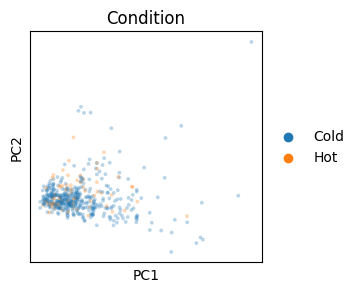

In [165]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
fig = sc.pl.pca(dds, color = 'Condition', size = 30, alpha=0.3, ax=ax, show=False)
# plt.savefig("gene/DESeq/deseq_pca.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
# plt.savefig("gene/DESeq/deseq_pca.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)

<Axes3D: title={'center': 'Condition'}, xlabel='PC1', ylabel='PC2', zlabel='PC3'>

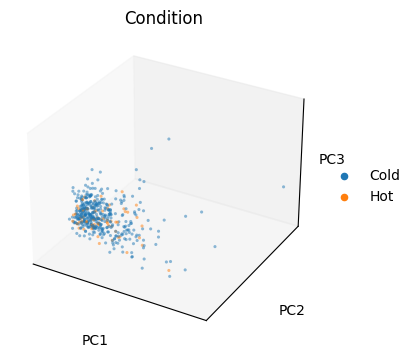

In [166]:


# Perform PCA on the DESeq dataset
sc.tl.pca(dds, n_comps=3)  # Specify the number of principal components to compute

# Create a 3D plot for the first three principal components
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the PCA results in 3D
sc.pl.pca(dds, color='Condition', size=300, alpha=0.5, ax=ax, show=False, components='all', projection='3d')

# # Save the 3D PCA plot to PDF and PNG files
# plt.savefig("gene/DESeq/deseq_pca_3d.pdf", dpi=600, bbox_inches='tight', pad_inches=0)
# plt.savefig("gene/DESeq/deseq_pca_3d.png", dpi=600, bbox_inches='tight', pad_inches=0)


In [167]:
#GSEA

import gseapy as gp
from gseapy.plot import gseaplot

In [168]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
A1BG,24.566236,0.124130,0.139099,0.892389,3.721845e-01,5.460773e-01,A1BG
A2M,32826.095128,0.032552,0.109887,0.296231,7.670540e-01,8.724728e-01,A2M
A2M-AS1,50.110389,0.054715,0.115115,0.475309,6.345670e-01,7.743583e-01,A2M-AS1
A2ML1,573.241347,0.162386,0.168132,0.965822,3.341333e-01,5.055986e-01,A2ML1
A4GALT,305.799207,0.177092,0.115925,1.527648,1.266000e-01,2.522353e-01,A4GALT
...,...,...,...,...,...,...,...
ZXDC,1732.123591,0.086360,0.045327,1.905237,5.674922e-02,1.398836e-01,ZXDC
ZYG11B,3684.699852,-0.102421,0.065734,-1.558120,1.192049e-01,2.412054e-01,ZYG11B
ZYX,6518.311135,0.706208,0.096504,7.317896,2.518882e-13,2.634293e-11,ZYX
ZZEF1,4664.128520,-0.053285,0.049008,-1.087279,2.769137e-01,4.426416e-01,ZZEF1


In [169]:
# filter before ranking
ranking = res[['stat']].dropna().sort_values('stat', ascending = False)
ranking

,stat
CA9,12.455476
VEGFA,10.248830
PLAT,10.031715
DSN1,9.686104
CCNB1,9.646345
...,...
ASCC1,-6.422087
GLUD1,-6.452852
PPP2R5A,-6.495691
SUFU,-6.652815


In [206]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [213]:
# set the out directory and graph_num, can give you all the information we need to be save, automatically!
pre_res = gp.prerank(rnk = ranking,
                     gene_sets = ['Reactome_2022', 'KEGG_2021_Human', 'MSigDB_Hallmark_2020'],
                     threads=8,
                     seed = 6, permutation_num = 100,
                     outdir="./mosi",
                    graph_num=5,
                     )

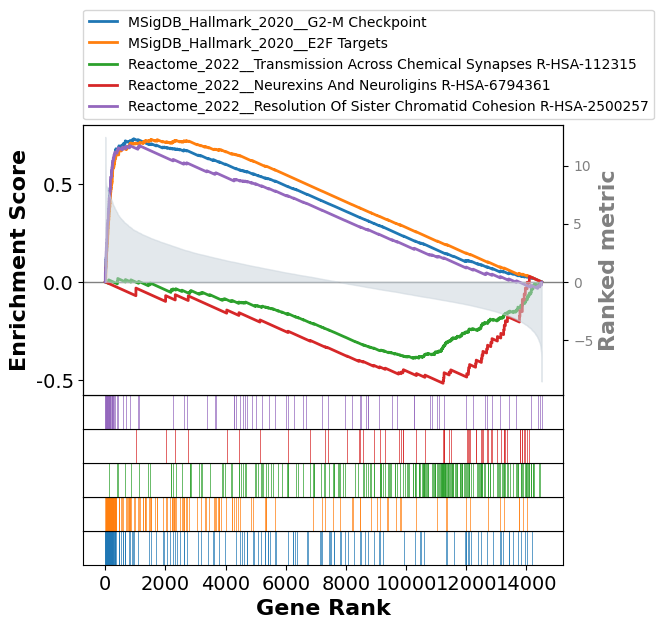

In [217]:
# pre_res.res2d.Term = [term.split("__")[-1] for term in pre_res.res2d.Term]
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4),
                #    ofname="gene/mosi"
                  )

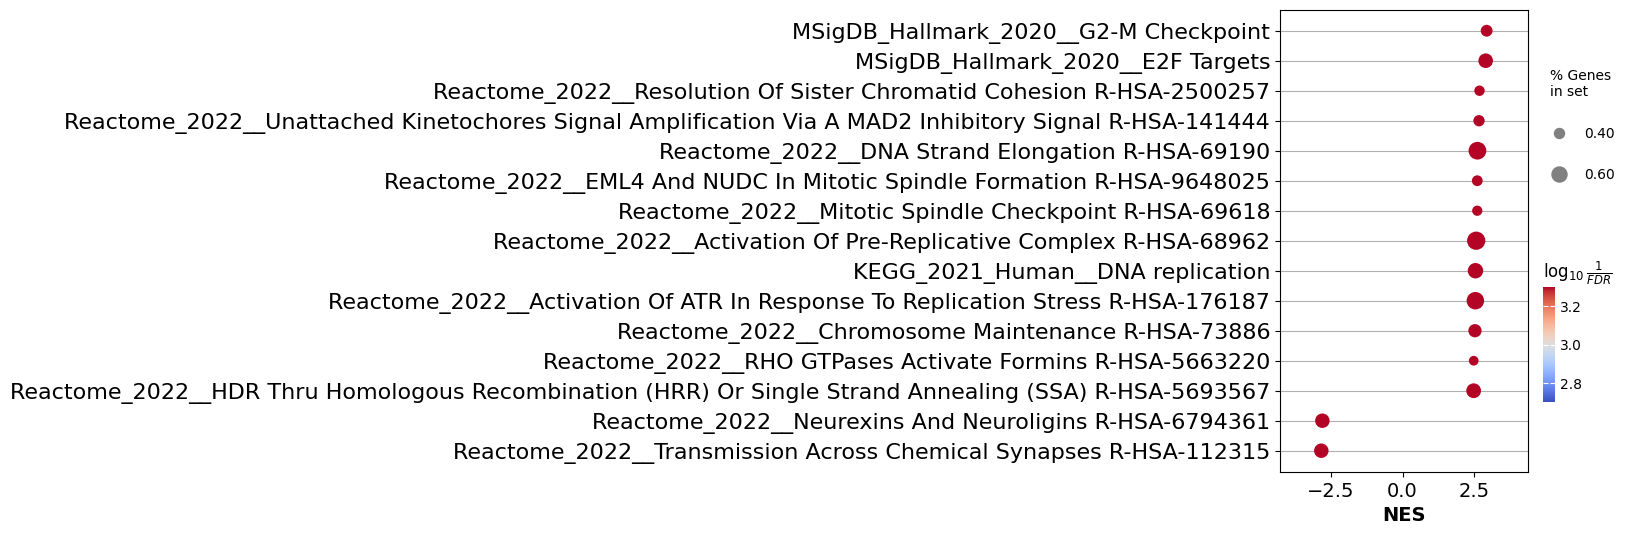

In [215]:
import matplotlib.pyplot as plt
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title=None,
             cmap=plt.cm.coolwarm,
             size=3, # adjust dot size
             top_term=15,
             figsize=(4,6), cutoff=0.25, show_ring=False,
            #  ofname="mosi",
             vmin=2,
             vmax=5,)

In [172]:
import numpy as np
import seaborn as sns

In [173]:
#volcano
from sanbomics.plots import volcano

In [174]:
mit_signatures = pd.read_csv("gene/data/signatures.csv")["Mitosis Process"].dropna().to_list()
mit_genes = [sym for sym in sigs["Symbol"] if sym in mit_signatures]
shape_dict = {"Mitosis-related": mit_genes}

log2fc_thresh = 1
pval_thresh = 1e-3
num_ann = 10
sigs['sorter'] = -np.log10(sigs["padj"])*sigs["log2FoldChange"]

df_sorted = sigs[(sigs["padj"]<pval_thresh) & (sigs["log2FoldChange"].abs()>log2fc_thresh)]
df_sorted = df_sorted.sort_values(by='sorter', ascending=False)

# Get top and bottom rows
top_rows = df_sorted["Symbol"].head(num_ann).to_list()
bottom_rows = df_sorted["Symbol"].tail(num_ann).to_list()
top_rows = top_rows+bottom_rows

mitosis_rows = df_sorted[df_sorted['Symbol'].isin(mit_genes)]
if len(mitosis_rows)>0:
    if len(mitosis_rows)>6:
        top_m_rows = mitosis_rows[mitosis_rows["sorter"]>0]["Symbol"].head(3).to_list()
        bottom_m_rows = mitosis_rows[mitosis_rows["sorter"]<0]["Symbol"].head(3).to_list()
        top_m_rows = top_m_rows + bottom_m_rows

        top_rows = list(set(top_rows).union(set(top_m_rows)))

/tmp/ipykernel_4163452/4174495648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs['sorter'] = -np.log10(sigs["padj"])*sigs["log2FoldChange"]


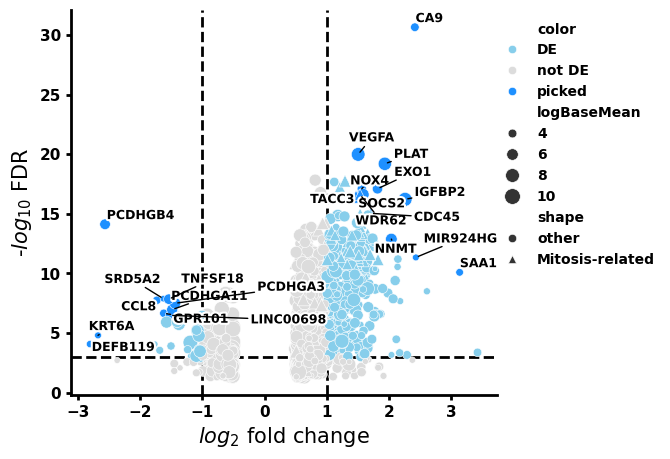

In [175]:
volcano(sigs, symbol='Symbol', baseMean="baseMean", log2fc_thresh=log2fc_thresh, pval_thresh=pval_thresh, to_label=top_rows, figsize=(5.5,5), colors=['skyblue', 'gainsboro', 'dodgerblue'], shape_dict=shape_dict,  fontsize=9, save="mosi")

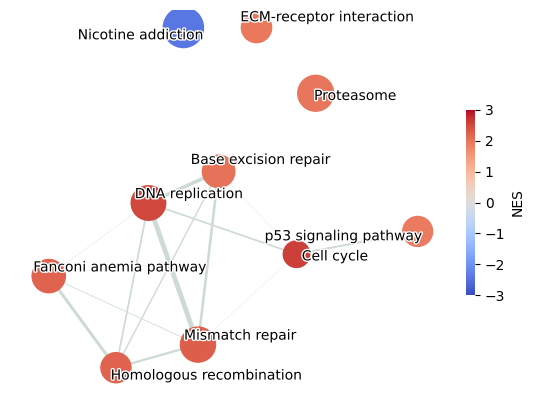

In [195]:
from gseapy import enrichment_map
import networkx as nx
from adjustText import adjust_text
import matplotlib.patheffects as pe
import matplotlib.cm as cm

# return two dataframe
top_term_num = 10
nodes, edges = enrichment_map(pre_res.res2d, top_term=top_term_num)
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for idx, row in nodes.iterrows():
    G.add_node(idx, **row.to_dict())

# Add edges to the graph
for idx, row in edges.iterrows():
    G.add_edge(row['src_idx'], row['targ_idx'], **row[['jaccard_coef', 'overlap_coef', 'overlap_genes']].to_dict())


fig, ax = plt.subplots(figsize=(6, 5))

# init node cooridnates
pos=nx.layout.kamada_kawai_layout(G)

# draw node
cmap = plt.cm.coolwarm
node_colors = list(nodes.NES)
vmin=-3
vmax=3
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=cmap,
                       node_color=node_colors,
                       node_size=list(nodes.Hits_ratio *1000),
                       vmin=vmin, vmax=vmax,
                       )

cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=ax,
                    fraction=0.02, pad=0.02
                    )
cbar.ax.set_aspect("auto")  # Increase this number to reduce the width
cbar.set_label('NES')
cbar.outline.set_visible(False)

# draw node label
texts = []
for node, (x, y) in pos.items():
    texts.append(ax.text(x, y, s=nodes.loc[node, 'Term'], 
                        #  bbox=dict(facecolor='white', alpha=0.1, edgecolor=None), 
                         path_effects=[pe.withStroke(linewidth=2, foreground="white")],
                         horizontalalignment='center', 
                         verticalalignment='center'))

# Use adjust_text to prevent overlap
adjust_text(texts)
    
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*top_term_num, edge_weight)),
                       edge_color='#CDDBD4')

# # Remove the box around the figure
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.savefig("mositemp.pdf")
